In [2]:
!pip install scipy

You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from scipy.stats import norm, linregress
from config import api_key
import requests
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [4]:
base_url = 'https://api.themoviedb.org/3/discover/movie?api_key=37002e338a92ba3d526a131788768a12&sort_by=release_date.asc&primary_release_date.gte=2016-01-01&primary_release_date.lte=2019-08-01'
param = {'api_key': api_key, 'year': 2016}
first_test = requests.get(base_url, params = {'page': 8}).json()
initial = first_test['results']
df = pd.DataFrame(initial)
df.head()

,popularity,id,video,vote_count,vote_average,title,release_date,original_language,original_title,genre_ids,backdrop_path,adult,overview,poster_path
0,1.213,346388,False,8,6.6,Black Mountain Poets,2016-03-13,en,Black Mountain Poets,"[18, 35]",/8s5g7C39wkd1MhV646BMu9T2ZTk.jpg,False,Two professional con artist sisters go on the ...,/uc3pBrKDRq8d0dScrhAgZB9e1W8.jpg
1,6.169,343173,False,184,5.3,The Rezort,2016-04-22,en,The Rezort,[27],/iohHu2oU1esBnvPqE038QfhnQut.jpg,False,"The ReZort, a post apocalyptic safari, offers ...",/oXeDhUJaOxUs1n6fHRhWVuuVBju.jpg
2,0.600,532607,False,0,0.0,Least Among Brethren,2015-06-22,en,Least Among Brethren,"[28, 18, 36]",None,False,"A story of faith, fear, and loyalty, centering...",/zwpmwc7ROSRnUtqZd6UVpmmknfU.jpg
3,1.450,343725,False,5,6.0,The Violators,2016-06-17,en,The Violators,[18],None,False,"When Shelly meets Rachel, two dysfunctional gi...",/dPzCFBBJenF0ajS7Wr0Tuh1rynP.jpg
4,0.600,391746,False,0,0.0,Battle Mountain: Graeme Obree's Story,2016-04-01,en,Battle Mountain: Graeme Obree's Story,[],None,False,"Addicted to breaking records, this former worl...",/5YQgLom59NKAXq3UtNz3Y3FUVRE.jpg


In [6]:
csv_path_1 = "Resources/tmdb_5000_movies.csv"
csv_path_2 = "Resources/tmdb_5000_credits.csv"
df_movies = pd.read_csv(csv_path_1)
df_credits = pd.read_csv(csv_path_2)
df_movies['vote_count'].value_counts()

0       62
1       53
2       46
4       43
3       41
        ..
2295     1
266      1
2359     1
314      1
2039     1
Name: vote_count, Length: 1609, dtype: int64

In [11]:
crew = json.loads(df_credits['crew'][0])
for i in crew:
    if i['job'] == 'Director':
        print(i['name'])
df_movies['production_companies'][0]

James Cameron


'[{"name": "Ingenious Film Partners", "id": 289}, {"name": "Twentieth Century Fox Film Corporation", "id": 306}, {"name": "Dune Entertainment", "id": 444}, {"name": "Lightstorm Entertainment", "id": 574}]'

In [5]:
# time series analysis
# dictionary key is a string of year and content is a list with num, revenue, rating, voting total
year_total = {}
period_total = {}
for i in df_movies.index:
    date = df_movies['release_date'][i]
    try:
        date_list = date.split('-')
    except:
        continue
    for j in range(3):
        date_list[j] = int(date_list[j])
    date_period = date_list[1]
    year = date_list[0] // 10
    if year in year_total.keys():
        year_total[year][0] += 1
        year_total[year][1] += df_movies['revenue'][i]
        year_total[year][2] += df_movies['vote_average'][i] * df_movies['vote_count'][i]
        year_total[year][3] += df_movies['vote_count'][i]
    else:
        year_total[year] = [1, df_movies['revenue'][i], 
                                    df_movies['vote_average'][i] * df_movies['vote_count'][i], 
                                    df_movies['vote_count'][i]]
    if date_period in period_total.keys():
        period_total[date_period][0] += 1
        period_total[date_period][1] += df_movies['revenue'][i]
        period_total[date_period][2] += df_movies['vote_average'][i] * df_movies['vote_count'][i]
        period_total[date_period][3] += df_movies['vote_count'][i]
    else:
        period_total[date_period] = [1, df_movies['revenue'][i], 
                                    df_movies['vote_average'][i] * df_movies['vote_count'][i], 
                                    df_movies['vote_count'][i]] 
columns = {'index': 'years', 0: 'total_num', 1: 'average_revenue', 2: 'rating', 
           3: 'voting_total'}
inflate = [25.4, 14.6, 18.7, 14.25, 9.57, 8.15, 4.77, 2.38, 1.68, 1.31, 1.08]
for i in year_total.keys():
    year_total[i][1] = year_total[i][1] / year_total[i][0]
    year_total[i][2] = year_total[i][2] / year_total[i][3]
for i in period_total.keys():
    period_total[i][1] = period_total[i][1] / period_total[i][0]
    period_total[i][2] = period_total[i][2] / period_total[i][3]
df_year = pd.DataFrame(year_total)
df_year = df_year.transpose()
df_year = df_year.rename(columns = columns)
df_year = df_year.sort_index()
df_year = df_year.reset_index()
df_year['years'] = [1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010]
for i in range(11):
    df_year['average_revenue'][i] = df_year['average_revenue'][i]  * inflate[i] /1000000
df_period = pd.DataFrame(period_total)
df_period = df_period.transpose()
df_period = df_period.rename(columns = columns)
df_period = df_period.sort_index()
df_period['month'] = [1,2,3,4,5,6,7,8,9,10,11,12]
df_period.head()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,total_num,average_revenue,rating,voting_total,month
1,382.0,2.863406e+07,6.241965,128480.0,1
2,326.0,5.613842e+07,6.575646,183288.0,2
3,372.0,7.310316e+07,6.611508,251744.0,3
4,350.0,7.392762e+07,6.642147,218069.0,4
5,363.0,1.339301e+08,6.794200,353405.0,5


In [6]:
df_year = df_year.drop(columns = 'index')
df_year.head()

,total_num,average_revenue,rating,voting_total,years
0,1.0,213.226675,7.400000,60.0,1910
1,4.0,98.580740,7.870620,742.0,1920
2,15.0,836.898601,7.389728,6182.0,1930
3,25.0,337.867941,7.333215,7325.0,1940
4,27.0,136.086167,7.838040,7203.0,1950


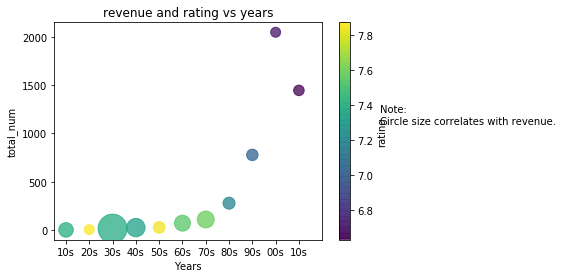

In [7]:
average_revenue = df_year['average_revenue'].tolist()
df_year.plot.scatter(x = 'years', y = 'total_num', s = average_revenue, 
                     c = 'rating', colormap='viridis', sharex=False, alpha = 0.75)
plt.xlim(1905, 2020)
plt.title("revenue and rating vs years")
plt.xlabel("Years")
plt.ylabel("total_num")
plt.xticks((1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010), 
           ('10s', '20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s', '00s', '10s'))
plt.text(2045, 1100, 'Note:\nCircle size correlates with revenue.')
plt.savefig("Output_image/years_vs_revenueAndRating.png", bbox_inches = 'tight')
plt.show()

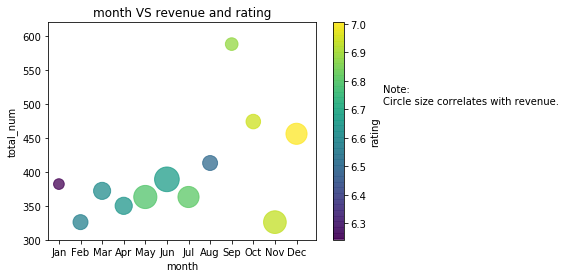

In [8]:
average_revenue_period = df_period['average_revenue'].tolist()
size = 0.000004
for i in range(len(average_revenue_period)):
    average_revenue_period[i] = average_revenue_period[i] * size
df_period.plot.scatter(x = 'month', y = 'total_num', s = average_revenue_period, 
                     c = 'rating', colormap='viridis', sharex=False, alpha = 0.75)
plt.xlim(0.5, 12.9)
plt.ylim(300, 620)
plt.title("month VS revenue and rating")
plt.xlabel("month")
plt.ylabel("total_num")
plt.xticks((1,2,3,4,5,6,7,8,9,10,11,12), 
           ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
plt.text(16, 500, 'Note:\nCircle size correlates with revenue.')
plt.savefig("Output_image/month_vs_revenueAndRating.png", bbox_inches = 'tight')
plt.show()

In [9]:
# runtime vs revenue
# means = df_movies['revenue'].mean()
# df_good_movies = df_movies.loc[(df_movies['revenue'] > means * 10), :]
# df_good_movies.plot.scatter(x = 'runtime', y = 'revenue')
# plt.show()

In [35]:
df_total = pd.merge(df_credits, df_movies, on = 'title')
for i in range(1265):
    name_init = 'Unnamed: '
    try:
        df_total = df_total.drop(columns = [name_init + str(i)])
        print(name_initial + str(i))
    except:
        continue
df_total.head()

,movie_id,title,cast,crew,budget,genres,homepage,id,keywords,original_language,...,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,vote_average,vote_count
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,...,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,7.2,11800
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,...,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",6.9,4500
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,...,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,6.3,4466
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,...,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,7.6,9106
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...",260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,...,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",6.1,2124


In [76]:
# actor
# actor dictionary key is a string of actor and content is a list with num, revenue, rating, voting total
actor_dict = {} 
for i in df_credits.index:
    try:
        actor = json.loads(df_total['cast'][i])
        for j in actor:
            name = j['name']
            if name in actor_dict.keys():
                actor_dict[name][0] += 1
                actor_dict[name][1] += df_total['revenue'][i]
                actor_dict[name][2] += df_total['vote_average'][i] * df_total['vote_count'][i]
                actor_dict[name][3] += df_total['vote_count'][i]
            else:
                actor_dict[name] = [1, df_total['revenue'][i], 
                                            df_total['vote_average'][i] * df_total['vote_count'][i], 
                                            df_total['vote_count'][i]]
    except:
        continue
for i in actor_dict.keys():
    actor_dict[i][2] = actor_dict[i][2] / actor_dict[i][3]
#     actor_dict[i][1] = actor_dict[i][1] / actor_dict[i][0]
df_actor = pd.DataFrame(actor_dict)
df_actor = df_actor.transpose()
df_actor = df_actor.rename(columns = columns)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


In [77]:
df_good_actor = df_actor.sort_values('total_num', ascending = False).head(n = 100)
df_actor.head()

,total_num,average_revenue,rating,voting_total
Sam Worthington,10.0,4.048278e+09,6.623792,21768.0
Zoe Saldana,20.0,6.270333e+09,7.295686,47079.0
Sigourney Weaver,33.0,5.537955e+09,6.909844,47838.0
Stephen Lang,11.0,3.173799e+09,7.004756,15244.0
Michelle Rodriguez,13.0,6.173045e+09,6.754691,30857.0


In [78]:
genres_dict = {}
for i in df_credits.index:
    try:
        genres = json.loads(df_total['genres'][i])
        actor = json.loads(df_total['cast'][i])
        for j in genres:
            name = j['name']
            if name in genres_dict.keys():
                for k in actor:
                    name_actor = k['name']
                    if name_actor not in genres_dict[name]:
                        genres_dict[name].append(name_actor)
            else:
                genres_dict[name] = [k['name'] for k in actor]
    except:
        continue

In [79]:
genres_dict
genres_actor = {}
for i in genres_dict.keys():
    genres_actor[i] = {}
    temp = [(0,'a'), (0,'a'), (0,'a'), (0,'a'), (0,'a')]
    for j in genres_dict[i]:
        genres_actor[i][j] = df_actor['average_revenue'][j] / 1000000000
        temp_tuple = (genres_actor[i][j], j)
        if temp[4][0] < temp_tuple[0]:
            temp[4] = temp_tuple
        temp.sort(reverse = True)
    genres_actor[i] = temp

In [80]:
for i in genres_actor.keys():
    genres_actor[i] = list(zip(genres_actor[i][0], genres_actor[i][1], 
                               genres_actor[i][2], genres_actor[i][3], genres_actor[i][4]))

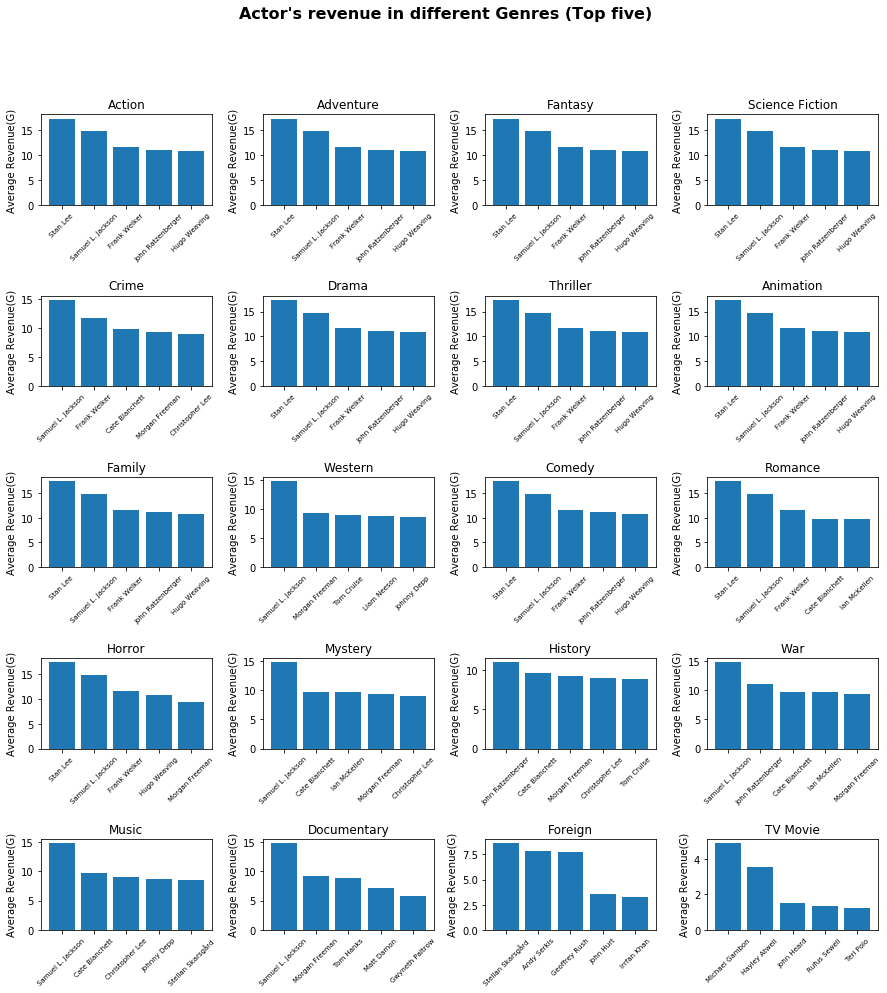

In [81]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8), (ax9, ax10, ax11, ax12), (ax13, ax14, ax15, ax16), 
      (ax17, ax18, ax19, ax20)) = plt.subplots(5, 4, sharex = False, sharey = False, figsize = (15,15))
plt.subplots_adjust(hspace = 1, wspace = 0.3)
fig_list = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, 
            ax11, ax12, ax13, ax14, ax15, ax16, ax17, ax18, ax19, ax20]
genres_key = list(genres_actor.keys())
fig.suptitle("Actor's revenue in different Genres (Top five)", fontsize=16, fontweight="bold")
for i in range(len(fig_list)):
    fig_list[i].bar(genres_actor[genres_key[i]][1], genres_actor[genres_key[i]][0])
    fig_list[i].tick_params(axis = 'x', rotation = 45, labelsize = 7)
    fig_list[i].set_title(genres_key[i])
    fig_list[i].set_ylabel('Average Revenue(G)')
plt.savefig("Output_image/Actor's_revenue_in_genres.png", bbox_inches = 'tight')
plt.show()

In [17]:
genres_total = {}
for i in df_total.index:
    genres = json.loads(df_total['genres'][i])
    for j in genres:
        name = j['name']
        if name in genres_total.keys():
            genres_total[name][0] += 1
            genres_total[name][1] += df_total['revenue'][i]
            genres_total[name][2] += df_total['vote_average'][i] * df_total['vote_count'][i]
            genres_total[name][3] += df_total['vote_count'][i]
        else:
            genres_total[name] = [1, df_total['revenue'][i], 
                                    df_total['vote_average'][i] * df_total['vote_count'][i], 
                                    df_total['vote_count'][i]]
for i in genres_total.keys():
    genres_total[i][1] = genres_total[i][1] / genres_total[i][0]
    genres_total[i][2] = genres_total[i][2] / genres_total[i][3]
df_genres = pd.DataFrame(genres_total)
df_genres = df_genres.transpose()
df_genres = df_genres.rename(columns = columns)
df_genres = df_genres.sort_values('total_num', ascending = False)
df_genres['order'] = np.arange(20)
df_genres.head()

,total_num,average_revenue,rating,voting_total,order
Drama,2300.0,5.208673e+07,7.074081,1223221.0,0
Comedy,1723.0,7.124812e+07,6.503291,904565.0,1
Thriller,1275.0,8.103039e+07,6.687812,986422.0,2
Action,1156.0,1.413794e+08,6.643109,1314643.0,3
Romance,895.0,6.000611e+07,6.707125,408144.0,4


In [18]:
df_genres_reset = df_genres.reset_index()
df_genres_reset.head()

,index,total_num,average_revenue,rating,voting_total,order
0,Drama,2300.0,5.208673e+07,7.074081,1223221.0,0
1,Comedy,1723.0,7.124812e+07,6.503291,904565.0,1
2,Thriller,1275.0,8.103039e+07,6.687812,986422.0,2
3,Action,1156.0,1.413794e+08,6.643109,1314643.0,3
4,Romance,895.0,6.000611e+07,6.707125,408144.0,4


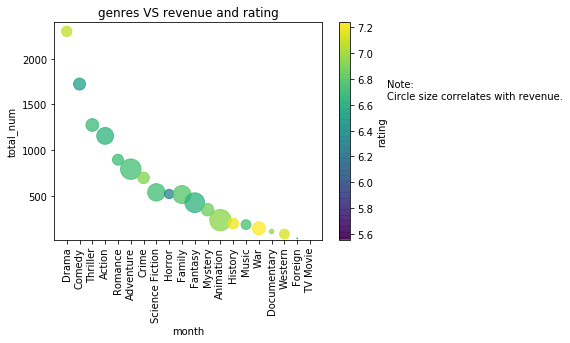

In [19]:
revenue_genres = df_genres['average_revenue'].tolist()
df_genres_reset = df_genres.reset_index()
name_list = df_genres_reset['index'].tolist()
size = 500000
for i in range(len(revenue_genres)):
    revenue_genres[i] = revenue_genres[i] / size
df_genres.plot.scatter(x = 'order', y = 'total_num', s = revenue_genres, 
                     c = 'rating', colormap='viridis', sharex=False, alpha = 0.75, rot = 90)
# plt.xlim(20, 3000)
plt.ylim(20, 2400)
plt.title("genres VS revenue and rating")
plt.xlabel("month")
plt.ylabel("total_num")
plt.xticks((0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19), 
           tuple(name_list))
plt.text(25, 1560, 'Note:\nCircle size correlates with revenue.')
plt.savefig("Output_image/genres_VS_revenueAndRating.png", bbox_inches = 'tight')
plt.show()

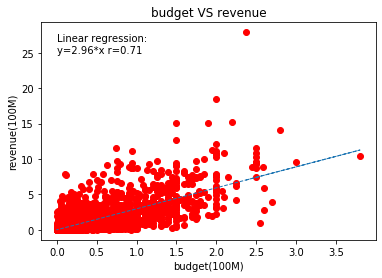

In [58]:
df_nozero = df_movies.loc[df_movies['budget'] != 0,:]
df_nozero = df_nozero.loc[df_movies['revenue'] != 0, :]
df_nozero['budget(100M)'] = df_nozero['budget'].divide(100000000)
df_nozero['revenue(100M)'] = df_nozero['revenue'].divide(100000000)
(slope, intercept, lr_r, lr_p, lr_err) = linregress(df_nozero['budget(100M)'], df_nozero['revenue(100M)'])
fit = slope * df_nozero['budget(100M)'] + intercept
plt.scatter(x = df_nozero['budget(100M)'], y = df_nozero['revenue(100M)'], c = 'red')
plt.plot(df_nozero['budget(100M)'], fit, ls = '--', linewidth = 1)
plt.title("budget VS revenue")
plt.xlabel("budget(100M)")
plt.ylabel("revenue(100M)")
plt.text(0, 25, ('Linear regression:\ny={:.2f}*x r={:.2f}').format(slope, lr_r))
plt.savefig("Output_image/budget_VS_revenue.png", bbox_inches = 'tight')
plt.show()

In [22]:
rating_dict = {}
for i in df_movies.index:
    rating = df_movies['vote_average'][i]
    if rating in rating_dict.keys():
        rating_dict[rating][0] += 1
        rating_dict[rating][1] += df_movies['vote_count'][i]
    else:
        rating_dict[rating] = [1, df_movies['vote_count'][i]]
df_rating = pd.DataFrame(rating_dict)
df_rating = df_rating.transpose()
df_rating = df_rating.rename(columns = {0: 'total_num', 1: 'voting_count'})
df_rating = df_rating.sort_index().reset_index().rename(columns = {'index': 'rating'})
df_rating = df_rating.drop([0])
df_rating.head()

,rating,total_num,voting_count
1,0.5,1,1
2,1.0,2,2
3,1.9,1,35
4,2.0,6,6
5,2.2,1,8


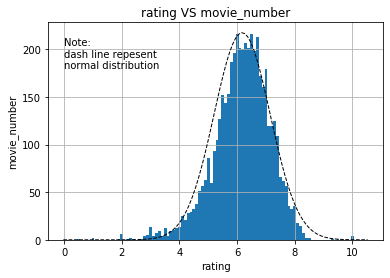

In [23]:
rating_list = df_rating['rating'].tolist()
total_rating_list = df_rating['total_num'].tolist()
df_no_zero = df_movies.loc[(df_movies['vote_average'] != 0),:]
data = df_no_zero['vote_average'].tolist()
mean, std = norm.fit(data)
plt.bar(rating_list, total_rating_list,  
        width = 0.1, align = 'center')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std) * 530
plt.plot(x, p, 'k', linewidth=1, ls = '--')
plt.title('rating VS movie_number')
plt.xlabel("rating")
plt.ylabel("movie_number")
plt.text(0, 180, 'Note:\ndash line repesent\nnormal distribution')
plt.grid()
plt.savefig("Output_image/rating_VS_movieNum.png", bbox_inches = 'tight')
plt.show()

In [36]:
df_total.head()

,movie_id,title,cast,crew,budget,genres,homepage,id,keywords,original_language,...,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,vote_average,vote_count
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,...,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,7.2,11800
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,...,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",6.9,4500
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,...,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,6.3,4466
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,...,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,7.6,9106
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...",260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,...,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",6.1,2124


In [94]:
keyword_list = []
# keyword_genres = {'genres': [{'keyword': [num, revenue, vote_average, vote_count]}]}
keyword_genres = {}
for i in df_total.index:
    keyword = json.loads(df_total['keywords'][i])
    genres = json.loads(df_total['genres'][i])
    for j in keyword:
        keyword_list.append(j['name'])
    for j in genres:
        genres_name = j['name']
        for k in keyword:
            keyword_name = k['name']
            if genres_name in keyword_genres.keys():
                genres_init = keyword_genres[genres_name]
                if keyword_name in genres_init.keys():
                    keyword_genres[genres_name][keyword_name][0] += 1
                    keyword_genres[genres_name][keyword_name][1] += df_total['revenue'][i]
                    keyword_genres[genres_name][keyword_name][2] += df_total['vote_average'][i] * df_total['vote_count'][i]
                    keyword_genres[genres_name][keyword_name][3] += df_total['vote_count'][i]
                else:
                    keyword_genres[genres_name][keyword_name] = [1, df_total['revenue'][i], 
                                        df_total['vote_average'][i] * df_total['vote_count'][i], 
                                        df_total['vote_count'][i]]
            else:
                keyword_genres[genres_name] = {}

In [87]:
for i in keyword_genres.keys():
    for j in keyword_genres[i].keys():
        keyword_genres[i][j][1] = keyword_genres[i][j][1] / keyword_genres[i][j][0] / 100000000
        keyword_genres[i][j][2] = keyword_genres[i][j][2] / keyword_genres[i][j][3]
keyword_top = {}
for i in keyword_genres.keys():
    temp = [(0,'a'), (0,'a'), (0,'a'), (0,'a'), (0,'a'), (0,'a'), (0,'a'), (0,'a'), (0,'a'), (0,'a')]
    for j in keyword_genres[i]:
        temp_tuple = (keyword_genres[i][j][2], j)
        if temp[9][0] < temp_tuple[0]:
            temp[9] = temp_tuple
        temp.sort(reverse = True)
    keyword_top[i] = temp
for i in keyword_top.keys():
    keyword_top[i] = list(zip(keyword_top[i][0], keyword_top[i][1], keyword_top[i][2], keyword_top[i][3], 
                              keyword_top[i][5], keyword_top[i][6], keyword_top[i][7], keyword_top[i][8],
                              keyword_top[i][9]
                             ))

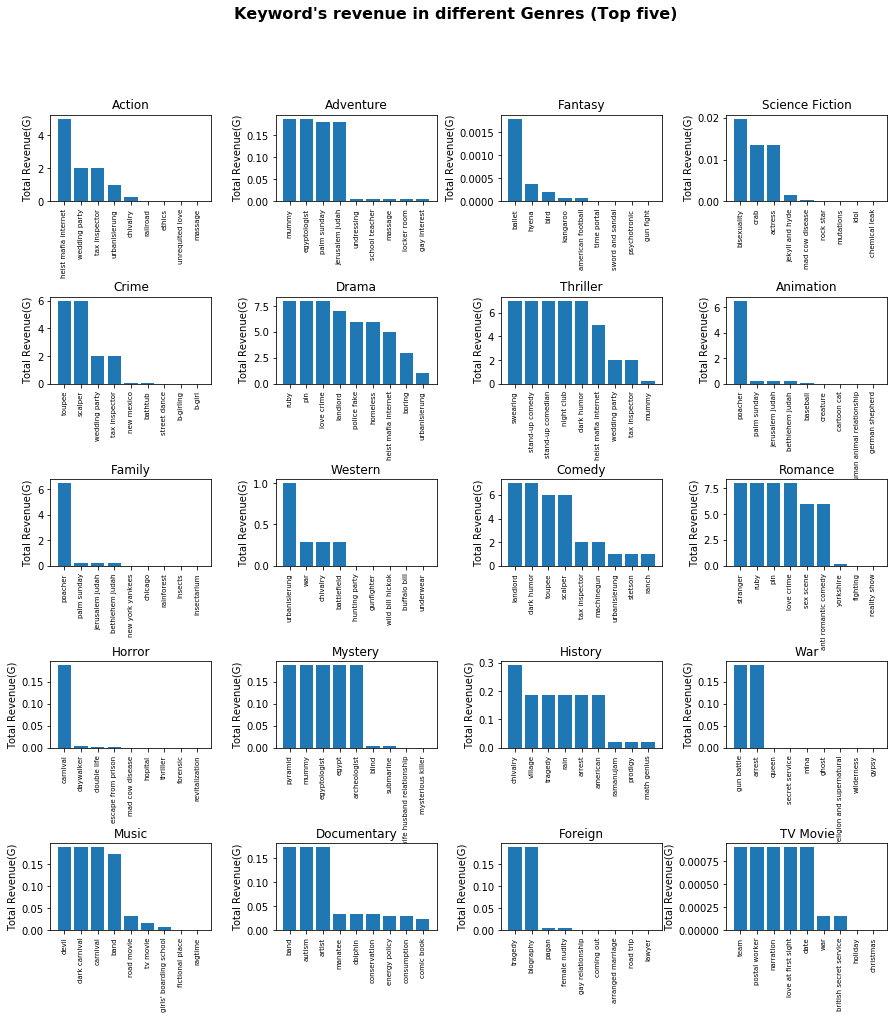

In [92]:
fig, ((axs1, axs2, axs3, axs4), (axs5, axs6, axs7, axs8), (axs9, axs10, axs11, axs12), (axs13, axs14, axs15, axs16), 
      (axs17, axs18, axs19, axs20)) = plt.subplots(5, 4, sharex = False, sharey = False, figsize = (15,15))
plt.subplots_adjust(hspace = 1.1, wspace = 0.4)
fig_list1 = [axs1, axs2, axs3, axs4, axs5, axs6, axs7, axs8, axs9, axs10, 
            axs11, axs12, axs13, axs14, axs15, axs16, axs17, axs18, axs19, axs20]
keyword_key = list(keyword_top.keys())
fig.suptitle("Keyword's revenue in different Genres (Top five)", fontsize=16, fontweight="bold")
for i in range(len(fig_list1)):
    fig_list1[i].bar(keyword_top[keyword_key[i]][1], keyword_top[keyword_key[i]][0])
    fig_list1[i].tick_params(axis = 'x', rotation = 90, labelsize = 7)
    fig_list1[i].set_title(keyword_key[i])
    fig_list1[i].set_ylabel('Total Revenue(G)')
plt.savefig("Output_image/keyword's_revenue_in_genres.png", bbox_inches = 'tight')
plt.show()

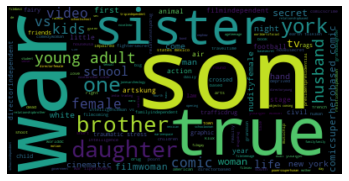

In [65]:
wordcloud = WordCloud().generate("".join(keyword_list))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()